# Домашнее задание. МОМО, Соревнование Kaggle, Regression

## 1. Импорт библиотек

In [1]:
#!pip install catboost

In [2]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"

from sklearn.pipeline import Pipeline # для создания Pipeline'ов.
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
from sklearn.model_selection import GridSearchCV # функция для поиска наилучших параметров по сетке

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR) # Чтобы на нас не ругались из-за того что matplot.lib проломали шрифты

import warnings
warnings.filterwarnings('ignore')

## 2. Набор данных

В качестве домашнего задания предлагается решить задачу предсказания оценки студентов за курсы, которое находится на [kaggle](https://www.kaggle.com/competitions/urfusf2024reg)

Данные можно скачать со страницы [соревнования](https://www.kaggle.com/competitions/urfusf2024reg/data)

#### **Файлы**
##### <u>Оригинальные:</u>
**assessments.csv** - Файл содержит информацию об оценках в модулях-презентациях. Обычно каждая презентация имеет ряд оценок, за которыми следует итоговый экзамен.

**courses.csv** - Файл содержит список всех доступных модулей и их презентаций.

**studentAssessment.csv** - Файл содержит результаты оценок студентов. Если учащийся не сдает оценку, результат не записывается. Итоговые экзаменационные материалы отсутствуют, если результат оценивания не хранится в системе.

**studentInfo.csv** - Файл содержит демографическую информацию об учащихся.

**studentRegistration.csv** - Файл содержит информацию о времени регистрации студента на презентацию модуля.

**studentVle.csv** - Фйал содержит информацию о взаимодействии каждого учащегося с материалами в VLE.

**vle.csv** - Файл содержит информацию о доступных материалах в VLE (Virtual Learning Environment). Обычно это html-страницы, pdf-файлы и т. д. Студенты имеют доступ к этим материалам в Интернете, и их взаимодействие с материалами записывается.

##### <u>Тренировочная и тестовая выборки</u>
**Test_Who.csv** - перечень id_student, code_modelu и code_presentation для тестовой выборки. ID - внутренний идентификатор для оценки на Kaggle

**Train_Who.csv** - перечень id_student, code_modelu и code_presentation для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle

**Train_Target_reg.csv** - целевая метрика для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle, как в файле **Train_Who.csv**

**Submission_reg.csv** - Пример файла для загрузки, в который проставлены все средние значения (кто знает может использовать для подгонки 👀). ID - внутренний идентификатор для оценки на Kaggle, как в файле **Test_Who.csv**

In [3]:
# Подгрузим данные в pandas dataframe
assessments = pd.read_csv('./data/assessments.csv')
results = pd.read_csv('./data/studentAssessment.csv')
courses = pd.read_csv('./data/courses.csv')
reg = pd.read_csv('./data/studentRegistration.csv')
stud_info = pd.read_csv('./data/studentInfo.csv')
materials = pd.read_csv('./data/vle.csv')
vle = pd.read_csv('./data/studentVle.csv')

## 3. Exploratory Data Analysis (EDA)

### 3.1. Просмотр таблиц
Посмотрим на каждую таблицу в отдельности:

#### 1) Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [4]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [5]:
assessments.sample(3)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
25,BBB,2013J,15004,CMA,96.0,1.0
180,GGG,2013J,37422,CMA,229.0,0.0
107,DDD,2014J,25367,TMA,195.0,25.0


In [6]:
assessments.describe()

,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


In [7]:
for col in assessments.columns:
    print(f"Number of unique values of '{col}' = {assessments[col].nunique()}")

Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'id_assessment' = 206
Number of unique values of 'assessment_type' = 3
Number of unique values of 'date' = 74
Number of unique values of 'weight' = 24


In [8]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

#### 2) Assessments results (результаты оценки)

1. **id_assessment** – идентификационный номер оценки.
2. **id_student** –уникальный идентификационный номер студента.
3. **date_submitted** – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
4. **is_banked** – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентаци

In [9]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [10]:
results.head()

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0


In [11]:
results.describe()

,id_assessment,id_student,date_submitted,is_banked
count,173912.000000,1.739120e+05,173912.000000,173912.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977
std,8829.784254,5.523952e+05,71.484148,0.104194
min,1752.000000,6.516000e+03,-11.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000
max,37443.000000,2.698588e+06,608.000000,1.000000


In [12]:
for col in results.columns:
    print(f"Number of unique values of '{col}' = {results[col].nunique()}")

Number of unique values of 'id_assessment' = 188
Number of unique values of 'id_student' = 23369
Number of unique values of 'date_submitted' = 312
Number of unique values of 'is_banked' = 2


In [13]:
results.isna().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
dtype: int64

#### 3) Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [14]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [15]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [16]:
for col in courses.columns:
    print(f"Number of unique values of '{col}' = {courses[col].nunique()}")

Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'module_presentation_length' = 7


In [17]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

#### 4) Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [18]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


In [19]:
reg.sample(3)

,code_module,code_presentation,id_student,date_registration
6353,BBB,2014B,2641682,-100.0
12149,CCC,2014J,642066,-29.0
24366,FFF,2013J,468947,-52.0


In [20]:
for col in reg.columns:
    print(f"Number of unique values of '{col}' = {reg[col].nunique()}")

Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'id_student' = 28785
Number of unique values of 'date_registration' = 332


In [21]:
reg.isna().sum()

code_module           0
code_presentation     0
id_student            0
date_registration    45
dtype: int64

#### 5) Student information (информация о студентах)

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [22]:
stud_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [23]:
stud_info.sample(3)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
4715,BBB,2013J,2573353,F,Yorkshire Region,Lower Than A Level,10-20,35-55,0,60,N
16337,DDD,2014B,46753,F,East Anglian Region,A Level or Equivalent,60-70%,35-55,0,60,N
2716,BBB,2013J,306964,F,Scotland,Lower Than A Level,20-30%,0-35,0,60,Y


In [24]:
stud_info.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


In [25]:
for col in stud_info.columns:
    print(f"Number of unique values of '{col}' = {stud_info[col].nunique()}")

Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'id_student' = 28785
Number of unique values of 'gender' = 2
Number of unique values of 'region' = 13
Number of unique values of 'highest_education' = 5
Number of unique values of 'imd_band' = 10
Number of unique values of 'age_band' = 3
Number of unique values of 'num_of_prev_attempts' = 7
Number of unique values of 'studied_credits' = 61
Number of unique values of 'disability' = 2


In [26]:
stud_info.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
dtype: int64

#### 6) VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [27]:
materials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [28]:
materials.sample(3)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
4321,526844,FFF,2013B,oucontent,NaN,NaN
932,704120,BBB,2013J,resource,25.0,25.0
198,546719,AAA,2013J,oucontent,1.0,1.0


In [29]:
for col in materials.columns:
    print(f"Number of unique values of '{col}' = {materials[col].nunique()}")

Number of unique values of 'id_site' = 6364
Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'activity_type' = 20
Number of unique values of 'week_from' = 30
Number of unique values of 'week_to' = 30


In [30]:
materials.isna().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

#### 7) VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

In [31]:
vle.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [32]:
vle.sample(3) 

,code_module,code_presentation,id_student,id_site,date,sum_click
1108990,BBB,2013J,440563,703732,176,6
7326108,FFF,2013J,608477,716216,5,11
7794857,FFF,2013J,175453,716638,88,1


In [33]:
vle.describe() 

,id_student,id_site,date,sum_click
count,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
mean,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00
max,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03


In [34]:
for col in vle.columns:
    print(f"Number of unique values of '{col}' = {vle[col].nunique()}")

Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4
Number of unique values of 'id_student' = 26074
Number of unique values of 'id_site' = 6268
Number of unique values of 'date' = 295
Number of unique values of 'sum_click' = 498


In [35]:
vle.isna().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

#### 8) Тренировочный и тестовый наборы данных

In [36]:
X_train = pd.read_csv('./data/Train_Who.csv')
y_train = pd.read_csv('./data/Train_Target_reg.csv')
X_test = pd.read_csv('./data/Test_Who.csv')

In [37]:
X_train.shape, y_train.shape, X_test.shape

((26074, 4), (26074, 2), (6519, 4))

In [38]:
X_train

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J
2,2,1674799,CCC,2014J
3,3,195246,FFF,2014J
4,4,582080,FFF,2013J
...,...,...,...,...
26069,26069,588477,AAA,2014J
26070,26070,653826,BBB,2014J
26071,26071,126411,BBB,2013B
26072,26072,547448,DDD,2013J


In [39]:
y_train.head(5)

,ID,weighted_score
0,0,64.9125
1,1,14.8625
2,2,61.4300
3,3,39.5000
4,4,9.2500


In [40]:
for col in X_train.columns:
    print(f"Number of unique values of '{col}' = {X_train[col].nunique()}")

Number of unique values of 'ID' = 26074
Number of unique values of 'id_student' = 23579
Number of unique values of 'code_module' = 7
Number of unique values of 'code_presentation' = 4


In [41]:
X_train[X_train['id_student'].duplicated()]

,ID,id_student,code_module,code_presentation
306,306,559912,CCC,2014J
348,348,48635,CCC,2014J
610,610,480928,CCC,2014B
665,665,527619,DDD,2013B
885,885,607896,CCC,2014B
...,...,...,...,...
26055,26055,528506,CCC,2014J
26058,26058,605540,CCC,2014J
26062,26062,634655,CCC,2014J
26063,26063,586818,GGG,2013J


In [42]:
X_train[X_train['id_student'] == 559912]

,ID,id_student,code_module,code_presentation
170,170,559912,CCC,2014B
306,306,559912,CCC,2014J
11480,11480,559912,EEE,2013J


### 3.2. Слияние таблиц

In [43]:
# Сливаем первые 3 таблицы с оценками
full_merged = pd.merge(stud_info, results, on=['id_student'], how='left')
full_merged = pd.merge(full_merged, assessments, on=['id_assessment', 'code_module', 'code_presentation'], how='left')

In [44]:
# Пример студента с двумя записями
X_train[X_train['id_student'] == 8462]

,ID,id_student,code_module,code_presentation
11563,11563,8462,DDD,2013J
19573,19573,8462,DDD,2014J


In [45]:
# Вспомогательная функция которую будем использовать для агрегации оценок:
def agg_func_assessment(x):
    d = {}
    d['is_banked'] = x['is_banked'].max() # установим максимальное значение
    d['weighted_date'] = (x['weight'] * x['date']).sum()/(x['weight'].sum()) if x['weight'].sum() != 0 else x['date'].mean() # установим взвешенное значение 
    d['weighted_date_submitted'] = (x['weight'] * x['date_submitted']).sum()/(x['weight'].sum()) if x['weight'].sum() != 0 else x['date_submitted'].mean() # установим взвешенное значение 
    return pd.Series(d, index=['is_banked', 'weighted_date', 'weighted_date_submitted'])

In [46]:
# применяем нашу агрегирующую функцию
df = full_merged.groupby(['id_student', 'code_module', 'code_presentation']).apply(agg_func_assessment)

In [47]:
# Формируем pandas-датасет
df = pd.DataFrame(df).reset_index()

In [48]:
# Пример вида временного датасета
df.head(3)

,id_student,code_module,code_presentation,is_banked,weighted_date,weighted_date_submitted
0,3733,DDD,2013J,NaN,NaN,NaN
1,6516,AAA,2014J,0.0,133.8000,130.900
2,8462,DDD,2013J,1.0,61.3125,60.375


In [49]:
# Объединяем временный датасет с имеющимся
full_merged = pd.merge(full_merged, df, on=['id_student', 'code_module', 'code_presentation'], how='left')

In [50]:
# Продолжаем дальше сливать таблицы
full_merged = pd.merge(full_merged, courses, on=['code_module', 'code_presentation'], how='left')

In [51]:
# удаляем ненужные колонки и дубликаты
full_merged = full_merged.drop(['id_assessment', 'is_banked_x', 'date', 'date_submitted', 'weight', 'assessment_type'], axis=1)
full_merged = full_merged.drop_duplicates()

In [52]:
# Продолжаем сливать таблицы
full_merged = pd.merge(full_merged, reg, on=['id_student', 'code_module', 'code_presentation'], how='left')

In [53]:
# Предварительно подготовим таблицу full_vle для последующего слияния
full_vle = pd.merge(vle, materials, on=['id_site', 'code_module', 'code_presentation'], how='left')
full_vle = full_vle.drop(['id_site', 'date', 'activity_type', 'week_from', 'week_to'], axis=1)

In [54]:
# Вспомогательная функция которую будем использовать для агрегации vle:
def agg_func_vle(x):
    d = {}
    d['sum_click_total'] = x['sum_click'].sum()
    return pd.Series(d, index=['sum_click_total'])

In [55]:
# Применим нашу агрегирующую функцию для vle и сформируем временный датасет
df = full_vle.groupby(['id_student', 'code_module', 'code_presentation']).apply(agg_func_vle)

In [56]:
# Преобразуем в pandas-датасет
df = pd.DataFrame(df).reset_index()

In [57]:
# Объединяем таблицы vle в одну
full_vle = pd.merge(full_vle, df, on=['id_student', 'code_module', 'code_presentation'], how='left')

In [58]:
# удаляем ненужные колонки (уже сагрегированы)
full_vle = full_vle.drop(['sum_click'], axis=1)
full_vle = full_vle.drop_duplicates()

In [59]:
# Получаем итоговую общую таблицу
full_merged = pd.merge(full_merged, full_vle, on=['id_student', 'code_module', 'code_presentation'], how='left')

In [60]:
# размерность общей таблицы
full_merged.shape

(32593, 17)

In [61]:
# Объединим с X_train для получения общей таблицы для обучения
X_train_merged = pd.merge(X_train, full_merged, on=['id_student', 'code_module', 'code_presentation'], how='left')
X_train_merged.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total
0,0,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,0.0,178.937500,176.625000,241,-36.0,1694.0
1,1,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,0.0,61.312500,61.312500,261,-32.0,692.0
2,2,1674799,CCC,2014J,M,South Region,HE Qualification,70-80%,55<=,0,60,N,0.0,72.235602,205.031414,269,-21.0,1963.0
3,3,195246,FFF,2014J,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,0.0,89.333333,93.166667,269,-124.0,2138.0
4,4,582080,FFF,2013J,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,0.0,19.000000,19.000000,268,-114.0,188.0


In [62]:
# Сводный список пропусков X_train
X_train_merged.isna().sum()

ID                               0
id_student                       0
code_module                      0
code_presentation                0
gender                           0
region                           0
highest_education                0
imd_band                       887
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
is_banked_y                   4717
weighted_date                 5434
weighted_date_submitted       4717
module_presentation_length       0
date_registration               37
sum_click_total               2710
dtype: int64

In [63]:
# Объединим с X_train для получения общей таблицы для тестирования
X_test_merged = pd.merge(X_test, full_merged, on=['id_student', 'code_module', 'code_presentation'], how='left')
X_test_merged.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,1.0,62.15,177.875,262,-92.0,297.0
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N,NaN,NaN,NaN,241,-109.0,NaN
2,26076,387276,BBB,2013B,F,North Western Region,Lower Than A Level,50-60%,35-55,1,180,N,NaN,NaN,NaN,240,-88.0,NaN
3,26077,692219,CCC,2014J,M,South Region,A Level or Equivalent,20-30%,0-35,0,90,N,0.0,18.00,21.000,269,-34.0,283.0
4,26078,516212,BBB,2013J,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,N,NaN,NaN,NaN,268,-134.0,NaN


In [64]:
# Сводный список пропусков X_test
X_test_merged.isna().sum()

ID                               0
id_student                       0
code_module                      0
code_presentation                0
gender                           0
region                           0
highest_education                0
imd_band                       224
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
is_banked_y                   1130
weighted_date                 1316
weighted_date_submitted       1130
module_presentation_length       0
date_registration                8
sum_click_total                655
dtype: int64

### 3.3. Подготовка данных

In [65]:
# Объединим таблицу с y_train 
X_train_merged = pd.concat([X_train_merged, y_train['weighted_score']], axis=1)

In [66]:
# Пример итоговой таблицы для обучения
X_train_merged.sample(5)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total,weighted_score
13483,13483,496590,FFF,2014B,M,South West Region,Lower Than A Level,20-30%,0-35,1,120,N,0.0,38.000000,33.500000,241,-40.0,733.0,17.750
24792,24792,1484804,AAA,2014J,F,West Midlands Region,A Level or Equivalent,40-50%,35-55,0,60,N,0.0,133.800000,145.600000,269,-88.0,1454.0,66.800
19682,19682,587619,FFF,2013J,M,Scotland,Lower Than A Level,80-90%,0-35,0,60,N,0.0,108.250000,106.375000,268,-88.0,6741.0,86.500
2034,2034,1380308,DDD,2014J,M,Wales,HE Qualification,90-100%,35-55,0,60,N,0.0,43.171429,180.314286,262,-57.0,416.0,73.875
10374,10374,626530,FFF,2014B,M,Wales,HE Qualification,30-40%,35-55,0,60,N,0.0,106.250000,105.250000,241,-17.0,3515.0,56.500


In [67]:
# Заполним пропуски, которые логично предсказать. На строках с отсутствием 'weighted_date_submitted' обучаться не будем.
X_train_merged['imd_band'].fillna('50-60%', inplace=True) # среднее значение признака
X_train_merged['sum_click_total'] = X_train_merged['sum_click_total'].fillna(X_train_merged.groupby(['code_module', 'code_presentation'])['weighted_date'].transform('median')) # медианное значение данного признака
X_train_merged['date_registration'].fillna(0, inplace=True) # заполним 0 - регистрация в день начала курса

In [68]:
# Оставшиеся пропуски просто удалим
X_train_merged.dropna(inplace=True)

In [69]:
X_train_merged.sample(5)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total,weighted_score
21207,21207,529991,FFF,2013B,M,South Region,Lower Than A Level,80-90%,35-55,1,120,N,0.0,104.750,107.375,240,-58.0,3388.0,44.2500
20022,20022,1472925,AAA,2013J,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,60,Y,0.0,133.800,135.500,268,20.0,939.0,62.2000
25238,25238,504956,FFF,2013B,M,Scotland,HE Qualification,30-40%,35-55,0,60,Y,1.0,19.000,20.000,240,-107.0,1318.0,8.5000
5939,5939,473008,DDD,2013B,F,Ireland,Lower Than A Level,0-10%,0-35,0,120,N,0.0,179.845,175.095,240,-101.0,2244.0,73.9325
17296,17296,2616978,FFF,2014B,M,South West Region,A Level or Equivalent,80-90%,0-35,0,60,N,0.0,106.250,106.000,241,-15.0,5037.0,97.0000


In [70]:
# Удалим ID-шники и очень разрозненный 'region'
X_train_merged = X_train_merged.drop(['ID', 'id_student', 'region'], axis=1)

In [71]:
X_train_merged.head()

,code_module,code_presentation,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total,weighted_score
0,DDD,2014B,F,A Level or Equivalent,50-60%,0-35,1,70,N,0.0,178.937500,176.625000,241,-36.0,1694.0,64.9125
1,DDD,2013J,M,A Level or Equivalent,20-30%,0-35,0,120,N,0.0,61.312500,61.312500,261,-32.0,692.0,14.8625
2,CCC,2014J,M,HE Qualification,70-80%,55<=,0,60,N,0.0,72.235602,205.031414,269,-21.0,1963.0,61.4300
3,FFF,2014J,M,Lower Than A Level,10-20,0-35,0,60,N,0.0,89.333333,93.166667,269,-124.0,2138.0,39.5000
4,FFF,2013J,M,Lower Than A Level,10-20,35-55,0,60,N,0.0,19.000000,19.000000,268,-114.0,188.0,9.2500


In [72]:
# 
# y_train = y_train.drop('ID', axis=1)

In [73]:
cat_columns = [] # создаем пустой список для имен колонок категориальных данных
num_columns = [] # создаем пустой список для имен колонок числовых данных

for column_name in X_train_merged.columns: # смотрим на все колонки в датафрейме
    if (X_train_merged[column_name].dtypes == object): # проверяем тип данных для каждой колонки
        cat_columns +=[column_name] # если тип объект - то складываем в категориальные данные
    else:
        num_columns +=[column_name] # иначе - числовые

# важно: если признак категориальный, но хранится в формате числовых данных, тогда код не сработает корректно


# выводим результат
print('Категориальные данные:\t ',cat_columns, '\n Число столбцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столбцов = ',len(num_columns))

Категориальные данные:	  ['code_module', 'code_presentation', 'gender', 'highest_education', 'imd_band', 'age_band', 'disability'] 
 Число столбцов =  7
Числовые данные:	  ['num_of_prev_attempts', 'studied_credits', 'is_banked_y', 'weighted_date', 'weighted_date_submitted', 'module_presentation_length', 'date_registration', 'sum_click_total', 'weighted_score'] 
 Число столбцов =  9


Построим графики числовых признаков:

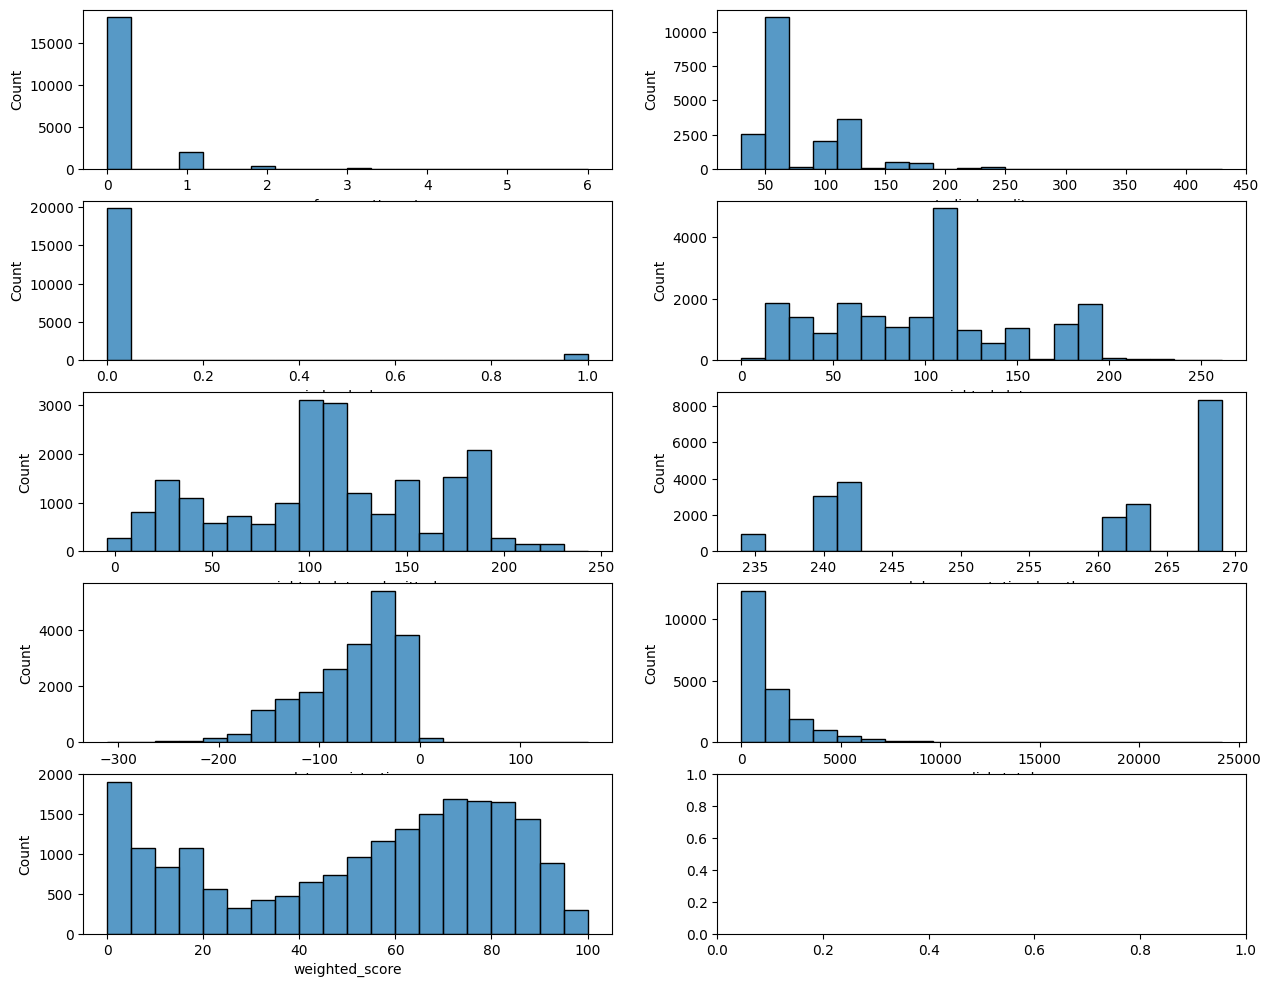

In [74]:
width = 2
height = int(np.ceil(len(num_columns) / width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(15, 12)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, column_name in enumerate(num_columns): # перебираем все числовые данные
    plt.subplot(height, width, idx + 1) # берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=X_train_merged, x=column_name, bins = 20); 

In [75]:
# Посмотрим на корреляцию числовых столбцов
X_train_merged[num_columns].corr().style.background_gradient(cmap = 'YlOrRd', vmin = -1, vmax=1) 

,num_of_prev_attempts,studied_credits,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total,weighted_score
num_of_prev_attempts,1.000000,0.182866,0.271420,-0.069918,-0.132986,-0.057247,-0.020551,-0.074718,-0.128955
studied_credits,0.182866,1.000000,0.075279,-0.183497,-0.151477,-0.033492,-0.055403,0.009879,-0.121175
is_banked_y,0.271420,0.075279,1.000000,-0.122596,-0.215185,-0.011981,-0.014438,-0.079787,-0.150759
weighted_date,-0.069918,-0.183497,-0.122596,1.000000,0.618553,0.013722,0.029897,0.139627,0.600216
weighted_date_submitted,-0.132986,-0.151477,-0.215185,0.618553,1.000000,0.075856,0.002470,0.195399,0.657714
module_presentation_length,-0.057247,-0.033492,-0.011981,0.013722,0.075856,1.000000,-0.046140,0.054859,0.065810
date_registration,-0.020551,-0.055403,-0.014438,0.029897,0.002470,-0.046140,1.000000,-0.048277,0.005710
sum_click_total,-0.074718,0.009879,-0.079787,0.139627,0.195399,0.054859,-0.048277,1.000000,0.460044
weighted_score,-0.128955,-0.121175,-0.150759,0.600216,0.657714,0.065810,0.005710,0.460044,1.000000


Применим следующие преобразования:

In [76]:
# Стандартизируем:
# даты и взвешенные даты приведем к стандартному виду:
num_pipe_std = Pipeline([
    ('scaler', StandardScaler())
])

num_std = ['weighted_date', 'weighted_date_submitted', 'date_registration'] 

In [77]:
# Степенное преобразование:
# Исходя из графиков применим степенное преобразование, т.к. сильное отклонение от "нормальности"
num_pipe_pwr = Pipeline([
    ('power', PowerTransformer())
])

num_pwr = ['sum_click_total', 'module_presentation_length', 'studied_credits']

In [78]:
# Применяем порядковое кодирование
cat_pipe_ord = Pipeline([
    ('encoder', OrdinalEncoder())
])

cat_ord = ['gender', 'imd_band', 'age_band', 'disability']

In [79]:
# Применяем One-hot кодирование
cat_pipe_ohe = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_ohe = ['code_module', 'code_presentation', 'highest_education']

In [80]:
preprocessors = ColumnTransformer(transformers=[
    ('num_std', num_pipe_std, num_std),
    ('num_pwr', num_pipe_pwr, num_pwr),
    ('cat_ord', cat_pipe_ord, cat_ord),
    ('cat_ohe', cat_pipe_ohe, cat_ohe),
    ('num_passth', 'passthrough', ['num_of_prev_attempts', 'is_banked_y', 'weighted_score']),
])

In [81]:
preprocessors

ColumnTransformer(transformers=[('num_std',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['weighted_date', 'weighted_date_submitted',
                                  'date_registration']),
                                ('num_pwr',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['sum_click_total',
                                  'module_presentation_length',
                                  'studied_credits']),
                                ('cat_ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder())]),
                                 ['gender', 'imd_band', 'age_band',
                                  'disability']),
                                ('cat_ohe',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['code_module', 'code_presentation',
                                  'highest_education']),
                                ('num_passth', 'passthrough',
                                 ['num_of_prev_attempts', 'is_banked_y',
                                  'weighted_score'])])

In [82]:
# обучаем преобразователь
preprocessors.fit(X_train_merged)

ColumnTransformer(transformers=[('num_std',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['weighted_date', 'weighted_date_submitted',
                                  'date_registration']),
                                ('num_pwr',
                                 Pipeline(steps=[('power',
                                                  PowerTransformer())]),
                                 ['sum_click_total',
                                  'module_presentation_length',
                                  'studied_credits']),
                                ('cat_ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder())]),
                                 ['gender', 'imd_band', 'age_band',
                                  'disability']),
                                ('cat_ohe',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['code_module', 'code_presentation',
                                  'highest_education']),
                                ('num_passth', 'passthrough',
                                 ['num_of_prev_attempts', 'is_banked_y',
                                  'weighted_score'])])

In [83]:
cat_ohe_names = preprocessors.transformers_[3][1]['onehot'].get_feature_names_out(cat_ohe)

# объединяем названия колонок в один список
columns = np.hstack([num_std,
                     num_pwr,
                    cat_ord,
                    cat_ohe_names,
                    ['num_of_prev_attempts', 'is_banked_y', 'weighted_score'],
                    ])

In [84]:
# Формируем общий трансформированный датасет для обучения
X_train_transformed = pd.DataFrame(preprocessors.transform(X_train_merged), columns=columns)
X_train_transformed.head()

,weighted_date,weighted_date_submitted,date_registration,sum_click_total,module_presentation_length,studied_credits,gender,imd_band,age_band,disability,...,code_presentation_2014B,code_presentation_2014J,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,num_of_prev_attempts,is_banked_y,weighted_score
0,1.547181,1.233568,0.639978,0.545882,-1.172856,0.054288,0.0,5.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,64.9125
1,-0.746867,-0.918918,0.723977,-0.239668,0.205039,1.203376,1.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8625
2,-0.533833,1.763818,0.954973,0.686112,1.059461,-0.285668,1.0,7.0,2.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,61.4300
3,-0.200375,-0.324311,-1.207998,0.768859,1.059461,-0.285668,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,39.5000
4,-1.572091,-1.708746,-0.998000,-1.201957,0.940592,-0.285668,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.2500


## 4. Построение и обучение модели машинного обучения

### 4.1. Подготовка выборок

In [85]:
y_train = X_train_merged['weighted_score']
X_train_transformed.drop('weighted_score', axis=1, inplace=True)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=42)

In [87]:
def grid_optimizer(model, X, y, param_grids):
    gs = GridSearchCV(model, 
                      param_grid=param_grids, 
                      cv=5, 
                      scoring='neg_mean_squared_error')
    gs.fit(X, y)
    print(f"Best MSE-score: {gs.best_score_}")
    print(f"Best params: {gs.best_params_}")
    return gs.best_estimator_

### 4.2. CatBoost

Используем CatBoost как наиболее лучшее решение на сегодняший день (см. Модуль про ансамблевые модели)

In [88]:
# Ищем наилучший набор гиперпараметров 
param_grid = {'iterations': [1000, 2000, 5000], 
              'learning_rate': [0.05, 0.02, 0.01], 
              'depth': [3, 5, 10]}
best_cbr = grid_optimizer(CatBoostRegressor(loss_function='RMSE', bagging_temperature=7, random_seed=42, verbose=0), X_train, y_train, param_grid)

Best MSE-score: -104.71547318749995
Best params: {'depth': 5, 'iterations': 5000, 'learning_rate': 0.02}


In [103]:
# Обучаем модель
cbr = CatBoostRegressor(iterations=5000, loss_function='RMSE', learning_rate=0.02, depth=5, bagging_temperature=7, random_seed=42, verbose=0)
cbr.fit(X_train, y_train)

In [104]:
print(f"r2 на тренировочной выборке: {r2_score(y_train, cbr.predict(X_train)):.4f}")
print(f"r2 на валидационной выборке: {r2_score(y_test, cbr.predict(X_test)):.4f}")

print(f"mse на тренировочной выборке: {mse(y_train, cbr.predict(X_train)):.4f}")
print(f"mse на валидационной выборке: {mse(y_test, cbr.predict(X_test)):.4f}")

r2 на тренировочной выборке: 0.9128
r2 на валидационной выборке: 0.8845
mse на тренировочной выборке: 76.6890
mse на валидационной выборке: 104.4138


## 4.3 Подготовка данных для отправки в kaggle

In [91]:
# Заполним пропуски, которые логично предсказать. На строках с отсутствием 'weighted_date_submitted' обучаться не будем.
# Аналогично с тренировочным датасетом
X_test_merged['imd_band'].fillna('50-60%', inplace=True)
X_test_merged['sum_click_total'] = X_test_merged['sum_click_total'].fillna(X_test_merged.groupby(['code_module', 'code_presentation'])['weighted_date'].transform('median'))

In [92]:
# Информация по пропускам
X_test_merged.isna().sum()

ID                               0
id_student                       0
code_module                      0
code_presentation                0
gender                           0
region                           0
highest_education                0
imd_band                         0
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
is_banked_y                   1130
weighted_date                 1316
weighted_date_submitted       1130
module_presentation_length       0
date_registration                8
sum_click_total                  0
dtype: int64

In [93]:
# Удаляем те значения у которых не было 'weighted_date_submitted' - это означает, что у них также нет оценки в проверочном датасете и они заполнены просто средними значениями
X_test_merged.dropna(inplace=True)

In [94]:
# Пример тестового датасета
X_test_merged.head(4)

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,is_banked_y,weighted_date,weighted_date_submitted,module_presentation_length,date_registration,sum_click_total
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,1.0,62.15,177.875,262,-92.0,297.0
3,26077,692219,CCC,2014J,M,South Region,A Level or Equivalent,20-30%,0-35,0,90,N,0.0,18.00,21.000,269,-34.0,283.0
5,26079,543853,BBB,2013B,F,West Midlands Region,Lower Than A Level,0-10%,0-35,0,120,N,0.0,116.16,119.560,240,-55.0,1805.0
6,26080,1467014,BBB,2013J,M,Wales,Lower Than A Level,70-80%,35-55,0,60,N,0.0,124.14,120.900,268,-16.0,1292.0


In [95]:
# Трансформируем датасет на пайплайне тренировончого датасета
X_test_merged['weighted_score'] = 52.319915119905914 # Предварительно добавим данный столбец, чтобы работал пайплайн
X_test_transformed = pd.DataFrame(preprocessors.transform(X_test_merged), columns=columns)
X_test_transformed.head()

,weighted_date,weighted_date_submitted,date_registration,sum_click_total,module_presentation_length,studied_credits,gender,imd_band,age_band,disability,...,code_presentation_2014B,code_presentation_2014J,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,num_of_prev_attempts,is_banked_y,weighted_score
0,-0.730534,1.256901,-0.536007,-0.886706,0.300425,-0.285668,1.0,5.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,52.319915
1,-1.591594,-1.671413,0.681977,-0.921090,1.059461,0.597765,1.0,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.319915
2,0.322827,0.168362,0.240983,0.605873,-1.220351,1.203376,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.319915
3,0.478461,0.193375,1.059972,0.296426,0.940592,-0.285668,1.0,7.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.319915
4,-1.134085,-1.212527,-0.767004,-1.454519,0.940592,1.203376,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.319915


In [96]:
# Проверим размерность датасета
X_test_transformed.shape

(5201, 29)

In [97]:
# Удаляем фиктивный столбец
X_test_transformed.drop('weighted_score', axis=1, inplace=True)

In [98]:
# Получаем предсказания на ранее обученной модели CatBoostRegressor
y_test_pred = cbr.predict(X_test_transformed)

In [99]:
submission = pd.read_csv('./data/Submission_reg.csv')

In [100]:
# Заполняем значениями только предсказанные значения, остальные оставляем средними
submission['weighted_score'][submission['ID'].isin(X_test_merged['ID'])] = y_test_pred

In [101]:
submission

,ID,weighted_score
0,26074,58.761959
1,26075,52.319915
2,26076,52.319915
3,26077,0.663200
4,26078,52.319915
...,...,...
6514,32588,5.260178
6515,32589,10.078569
6516,32590,73.236577
6517,32591,77.270412


In [102]:
# Выгружаем в файл
submission.to_csv('./data/Test_prediction.csv', columns=['ID', 'weighted_score'], index=False)